<a href="https://colab.research.google.com/github/mark-morelos/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [40]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [41]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [42]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [43]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [44]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood','Mass (g)', 'Density (g/mL)'])

In [45]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [46]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [47]:
df['Great'].dtype

dtype('bool')

In [48]:
df['Great'] = df['Great'].astype(int)
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [49]:
import numpy as np
df = df.replace(np.nan, 0)
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,x,x,x,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
1,California,1/24/2016,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,x,x,x,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2,Carnitas,1/24/2016,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,x,x,0,0,0,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
3,Asada,1/24/2016,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,x,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,0.0,0.0,0.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,x,x,0,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1


In [50]:
df.replace({'x':1}, inplace=True)
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
1,California,1/24/2016,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2,Carnitas,1/24/2016,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
3,Asada,1/24/2016,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
4,California,1/27/2016,4.0,3.8,1,6.59,4.0,0.0,0.0,0.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1


In [51]:
# check for Date dtype
df['Date'].sort_values()

305    1/10/2017
306    1/12/2017
307    1/12/2017
308    1/12/2017
309    1/12/2017
         ...    
223     9/5/2016
381     9/5/2017
382     9/5/2017
225     9/9/2016
224     9/9/2016
Name: Date, Length: 421, dtype: object

In [52]:
# convert Date dtype tp datetime value
df['Date'] = pd.to_datetime(df['Date'])
type(df['Date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [53]:
# check Date dtype after conversion
df['Date'].sort_values()

109   2011-05-16
112   2015-04-20
0     2016-01-18
3     2016-01-24
1     2016-01-24
         ...    
415   2019-08-27
414   2019-08-27
416   2019-08-27
422   2019-08-27
77    2026-04-25
Name: Date, Length: 421, dtype: datetime64[ns]

In [54]:
# extract the Year from the date to prepare data for Test, Train and Val splits
df['Year'] = df['Date'].dt.year
df[['Date', 'Year']].sample(5)

,Date,Year
58,2016-04-03,2016
224,2016-09-09,2016
215,2016-08-30,2016
2,2016-01-24,2016
392,2018-04-09,2018


In [55]:
# train/validate/test splits
train = df[df['Year']<=2016]
val = df[df['Year']==2017]
test = df[df['Year']>=2018]

train.shape, val.shape, test.shape

((298, 58), (85, 58), (38, 58))

In [56]:
train.isnull().sum()

Burrito          0
Date             0
Yelp             0
Google           0
Chips            0
Cost             0
Hunger           0
Length           0
Circum           0
Volume           0
Tortilla         0
Temp             0
Meat             0
Fillings         0
Meat:filling     0
Uniformity       0
Salsa            0
Synergy          0
Wrap             0
Unreliable       0
NonSD            0
Beef             0
Pico             0
Guac             0
Cheese           0
Fries            0
Sour cream       0
Pork             0
Chicken          0
Shrimp           0
Fish             0
Rice             0
Beans            0
Lettuce          0
Tomato           0
Bell peper       0
Carrots          0
Cabbage          0
Sauce            0
Salsa.1          0
Cilantro         0
Onion            0
Taquito          0
Pineapple        0
Ham              0
Chile relleno    0
Nopales          0
Lobster          0
Queso            0
Egg              0
Mushroom         0
Bacon            0
Sushi       

In [57]:
# baselines - checking mean
df.describe()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,Carrots,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Zucchini,Great,Year
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.00000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.0,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,0.803325,0.861283,6.949834,3.470428,13.469881,14.774703,0.524941,3.519477,3.603325,3.50000,3.514608,3.509810,3.412708,3.171734,3.569952,3.951544,0.078385,0.002375,0.004751,0.009501,0.009501,0.002375,0.0,0.011876,0.007126,0.007126,0.004751,0.030879,0.002375,0.432304,2016.410926
std,1.590489,1.698009,1.746725,0.861041,9.570803,10.541694,0.391316,0.794438,1.250767,1.04265,0.850634,1.114702,1.092065,1.199845,0.918510,1.163504,0.269096,0.048737,0.068842,0.097125,0.097125,0.048737,0.0,0.108459,0.084214,0.084214,0.068842,0.173195,0.048737,0.495985,0.896965
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,0.000000,0.000000,6.250000,3.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000
50%,0.000000,0.000000,6.950000,3.500000,18.500000,21.000000,0.680000,3.500000,4.000000,3.70000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000
75%,0.000000,0.000000,7.840000,4.000000,20.500000,22.500000,0.830000,4.000000,4.500000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2017.000000
max,4.500000,5.000000,25.000000,5.000000,26.000000,29.000000,1.540000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2026.000000


In [58]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

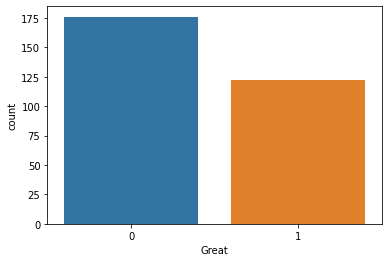

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y_train);

In [60]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [61]:
# Accuracy

from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5906040268456376

In [62]:
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [63]:
train.describe()




,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,Carrots,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Zucchini,Great,Year
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.0,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,0.928523,0.986913,6.757919,3.433725,11.645067,12.870302,0.450134,3.472315,3.519799,3.432047,3.507215,3.457819,3.373154,3.101510,3.516443,3.928523,0.090604,0.003356,0.003356,0.013423,0.013423,0.003356,0.0,0.013423,0.010067,0.010067,0.006711,0.043624,0.003356,0.409396,2015.979866
std,1.679213,1.776823,1.542546,0.873812,9.908151,10.958878,0.394904,0.797606,1.262157,1.068136,0.873048,1.143324,1.120343,1.254644,0.963831,1.207535,0.287528,0.057928,0.057928,0.115270,0.115270,0.057928,0.0,0.115270,0.099997,0.099997,0.081785,0.204601,0.057928,0.492550,0.295187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,0.000000,0.000000,6.250000,3.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000
50%,0.000000,0.000000,6.725000,3.500000,17.890000,20.500000,0.640000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.000000,3.725000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000
75%,0.000000,0.000000,7.500000,4.000000,20.000000,22.000000,0.770000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2016.000000
max,4.500000,4.900000,11.950000,5.000000,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000


In [64]:
# Trying Linear Regression

# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Meat:filling', 'Uniformity', 'Salsa']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([ 0.41159498,  0.11416995,  0.57233273,  0.62519746,  0.24242905,
        0.33129822,  0.54957305,  0.37520747, -0.11142746,  0.50708432,
        0.50643783,  0.44212311,  0.18201045,  0.4846246 ,  0.72358768,
        0.26909098,  0.38493698,  0.38752737,  0.5904583 ,  0.72358768,
        0.62228383,  0.69176215,  0.28493053,  0.45409646,  0.48753822,
        0.55863277,  0.74993077,  0.30899374,  0.51774752, -0.16342401,
        0.58318723,  0.52227738,  0.48255758,  0.44665297,  0.10836599,
        0.17909683,  0.60062584,  0.48300836,  0.51047644,  0.56137399,
        0.35311145,  0.45150167,  0.51192027,  0.54342696,  0.37453767,
        0.27878444,  0.28040067,  0.58431221,  0.54634059,  0.24566151,
        0.24857514,  0.42258977,  0.72811754,  0.69337838,  0.4746123 ,
        0.40416425,  0.38461815,  0.66994892,  0.45150167,  0.49368432,
        0.16971827,  0.33598332,  0.24534268,  0.45279907,  0.31675606,
        0.48915446,  0.61905137,  0.86577678,  0.48624083,  0.64

In [65]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Meat:filling    0.133129
Uniformity      0.069478
Salsa           0.072711
dtype: float64

In [66]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))


Validation Accuracy 0.6941176470588235


In [67]:
log_reg.predict(X_val_imputed)

array([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [ ]:
log_reg.coef_

In [68]:
features = ['Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat:filling']
target = 'Great'

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 8), (298,), (85, 8), (85,))

In [69]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = LogisticRegression()

In [70]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train_encoded.head()

,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat:filling
0,6.49,3.0,0.0,0.0,0.0,3.0,5.0,4.0
1,5.45,3.5,0.0,0.0,0.0,2.0,3.5,2.0
2,4.85,1.5,0.0,0.0,0.0,3.0,2.0,4.5
3,5.25,2.0,0.0,0.0,0.0,3.0,2.0,4.0
4,6.59,4.0,0.0,0.0,0.0,4.0,5.0,4.5


In [71]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [73]:
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)

accuracy_score(y_val, y_pred)

0.6352941176470588

In [74]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients

Cost            0.233892
Hunger          0.261561
Length         -0.651011
Circum          0.053516
Volume          0.449213
Tortilla        0.853798
Temp            0.264365
Meat:filling    1.026398
dtype: float64

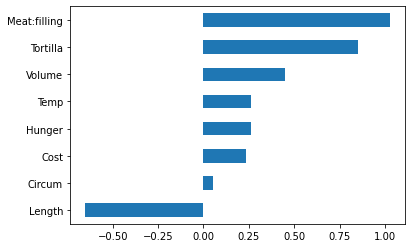

In [75]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();